<a href="https://colab.research.google.com/github/Uniholder/DeepLearningSchool/blob/main/VitualTryOn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Thu Mar 24 10:08:23 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torch
torch.__version__

'1.10.0+cu111'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Install cuDNN

In [4]:
# !tar xzvf drive/MyDrive/jobs/cudnn-11.3-linux-x64-v8.2.1.32.tgz
# !sudo cp cuda/include/cudnn*.h /usr/local/cuda/include 
# !sudo cp -P cuda/lib64/libcudnn* /usr/local/cuda/lib64 
# !sudo chmod a+r /usr/local/cuda/include/cudnn*.h /usr/local/cuda/lib64/libcudnn*

In [5]:
# !pip install pycuda

Install TensorRT

In [6]:
# !tar xzvf drive/MyDrive/jobs/TensorRT-8.0.1.6.Linux.x86_64-gnu.cuda-11.3.cudnn8.2.tar.gz
# !export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/content/TensorRT-8.0.1.6/lib
# %cd /content/TensorRT-8.0.1.6/python
# !python3 -m pip install tensorrt-8.0.1.6-cp37-none-linux_x86_64.whl
# %cd /content/TensorRT-8.0.1.6/uff
# !python3 -m pip install uff-0.6.9-py2.py3-none-any.whl
# %cd /content/TensorRT-8.0.1.6/graphsurgeon
# !python3 -m pip install graphsurgeon-0.4.5-py2.py3-none-any.whl
# %cd /content/TensorRT-8.0.1.6/onnx_graphsurgeon
# !python3 -m pip install onnx_graphsurgeon-0.3.10-py2.py3-none-any.whl

Install Torch-TensorRT

In [7]:
# !pip3 install torch-tensorrt -f https://github.com/NVIDIA/Torch-TensorRT/releases

In [8]:
# import torch
# torch.__version__

Installation of torch-tensorrt downgrades torch to 1.10.1+cu102 somewhy. But it must be cu111.

In [9]:
# # reinstall torch 1.10.0+cu111
# !pip install torch==1.10.0+cu111 -f https://download.pytorch.org/whl/cu111/torch_stable.html

In [10]:
# !sudo apt-get update
# !sudo apt-get install libnvinfer-plugin8

In [11]:
# libnvinfer8=8.2.1-1+cuda11.4 libnvparsers8=8.2.1-1+cuda11.4 libnvonnxparsers8=8.2.1-1+cuda11.4 libnvinfer-dev=8.2.1-1+cuda11.4 libnvinfer-plugin-dev=8.2.1-1+cuda11.4 libnvparsers-dev=8.2.1-1+cuda11.4 libnvonnxparsers-dev=8.2.1-1+cuda11.4 

In [12]:
!pip install efficientnet-pytorch
!pip install torch-summary

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=4d501c1fb10c86d6bb62a0269bc382d4d9d206d8f5487f18ec6df604e20b45a9
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch


# Download and prepare data

In [13]:
import os

PATH_TO_DATA = 'drive/MyDrive/datasets/'

In [ ]:
!unzip drive/MyDrive/datasets/img.zip

In [15]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn as nn
import torch
from torchsummary import summary
# import torch_tensorrt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from tqdm.notebook import tqdm
import copy

In [16]:
DEVICE = torch.device("cuda")
RESCALE_SIZE = 224

Read description of the data.

In [17]:
description = pd.read_csv(os.path.join(PATH_TO_DATA, 'df.csv'), index_col=0)
description

,image_name,positions
0,img/WOMEN/Blouses_Shirts/id_00000001/02_1_fron...,front
1,img/WOMEN/Blouses_Shirts/id_00000001/02_2_side...,side
2,img/WOMEN/Blouses_Shirts/id_00000001/02_3_back...,back
3,img/WOMEN/Blouses_Shirts/id_00000001/02_4_full...,full
4,img/WOMEN/Dresses/id_00000002/02_1_front.jpg,front
...,...,...
41110,img/WOMEN/Jackets_Coats/id_00007982/12_2_side.jpg,side
41111,img/WOMEN/Jackets_Coats/id_00007982/12_3_back.jpg,back
41112,img/WOMEN/Jackets_Coats/id_00007982/13_1_front...,front
41113,img/WOMEN/Jackets_Coats/id_00007982/13_2_side.jpg,side


Look at label values distribution.

In [18]:
description['positions'].value_counts()

front    12861
side     10923
back     10661
full      6670
Name: positions, dtype: int64

In [19]:
description[description.image_name.str.contains('img/MEN/Denim/id_00000080/')]

,image_name,positions
365,img/MEN/Denim/id_00000080/01_1_front.jpg,front
366,img/MEN/Denim/id_00000080/01_2_side.jpg,side
367,img/MEN/Denim/id_00000080/01_3_back.jpg,back


In [20]:
!ls -l img/MEN/Denim/id_00000080/

total 60
-rwxr-xr-x 1 root root 14866 Jul  2  2015 01_1_front.jpg
-rwxr-xr-x 1 root root 11706 Jul  2  2015 01_2_side.jpg
-rwxr-xr-x 1 root root 13857 Jul  2  2015 01_3_back.jpg
-rwxr-xr-x 1 root root 13083 Jul  2  2015 01_7_additional.jpg


Now we create Dataset class for data processing. __getitem__ method carries out RandomHorizontalFlip augmentation. This type of augmentation doesn't change image target label.

In [21]:
class PosesDataset(Dataset):
    def __init__(self, description):
        '''
        description: pandas dataframe with columns:
            - image_name: paths to images
            - positions: label column
        '''
        description.reset_index(drop=True, inplace=True)
        self.files = description['image_name']
        
        self.labels = description['positions']
        self.label_encoder = LabelEncoder()
        self.label_encoder.fit(self.labels)
        
        self.len_ = len(self.files)
        # self.precision = precision
    
    def __len__(self):
        return self.len_
    
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
    
    def __getitem__(self, index):
        transform = transforms.Compose([
#                 transforms.RandomResizedCrop(224),
                transforms.Resize((RESCALE_SIZE, RESCALE_SIZE)),
#                 transforms.CenterCrop(224),
                transforms.RandomHorizontalFlip(), # augmentation
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ])
        
        x = self.load_sample(self.files[index])
        label = self.labels[index]
        label_id = self.label_encoder.transform([label])
        y = label_id.item()
        x = transform(x)
        return x, y

Split dataset to 3 parts:
- train
- validation
- test (holdout for inference testing)

In [22]:
train_val_imgs, test_img = train_test_split(description, stratify=description.positions, random_state=0, test_size=5000)
train_imgs, val_img = train_test_split(train_val_imgs, stratify=train_val_imgs.positions, random_state=0)

In [23]:
train_dataset = PosesDataset(train_imgs)
val_dataset = PosesDataset(val_img)
test_dataset = PosesDataset(test_img)

Now we visualize some random images from the dataset.

In [24]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

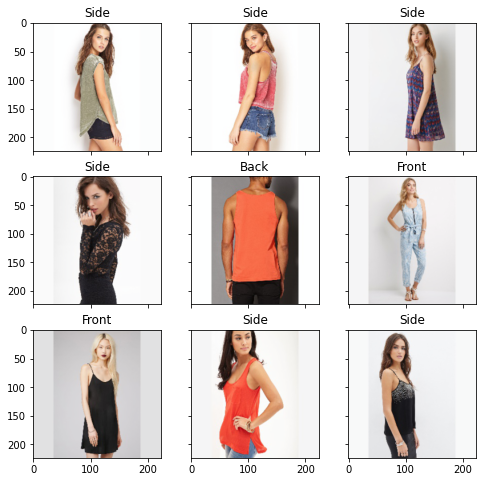

In [25]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(), val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val, title=img_label, plt_ax=fig_x)

## Model

Let's use Transfer learning technique.

We use pretrained model, change last fully-connected layer and fit the whole model for a few epochs. We won't freeze layers as our dataset differs quite a lot from that used for pretraing.

In [27]:
# !pip install timm

In [28]:
from torchvision.models.alexnet import alexnet
from torchvision.models.resnet import resnet50, resnet18
from efficientnet_pytorch import EfficientNet
# import timm

In [29]:
model = EfficientNet.from_pretrained('efficientnet-b0')
# model = alexnet(pretrained=True).eval().cuda()
# model = resnet18(pretrained=True).eval().cuda()
# model = efficientnet_b0 = timm.create_model('efficientnet_b0', pretrained=True).eval().cuda()
model

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b0


EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=

In [30]:
model.classifier = nn.Linear(1280, 4)

In [31]:
summary(model.cuda(), (3, 224, 224))

Layer (type:depth-idx)                             Output Shape              Param #
├─Conv2dStaticSamePadding: 1-1                     [-1, 32, 112, 112]        --
|    └─ZeroPad2d: 2-1                              [-1, 3, 225, 225]         --
├─BatchNorm2d: 1-2                                 [-1, 32, 112, 112]        64
├─MemoryEfficientSwish: 1-3                        [-1, 32, 112, 112]        --
├─ModuleList: 1                                    []                        --
|    └─MBConvBlock: 2-2                            [-1, 16, 112, 112]        --
|    |    └─Conv2dStaticSamePadding: 3-1           [-1, 32, 112, 112]        288
|    |    └─BatchNorm2d: 3-2                       [-1, 32, 112, 112]        64
|    |    └─MemoryEfficientSwish: 3-3              [-1, 32, 112, 112]        --
|    |    └─Conv2dStaticSamePadding: 3-4           [-1, 8, 1, 1]             264
|    |    └─MemoryEfficientSwish: 3-5              [-1, 8, 1, 1]             --
|    |    └─Conv2dStaticSamePaddi

Layer (type:depth-idx)                             Output Shape              Param #
├─Conv2dStaticSamePadding: 1-1                     [-1, 32, 112, 112]        --
|    └─ZeroPad2d: 2-1                              [-1, 3, 225, 225]         --
├─BatchNorm2d: 1-2                                 [-1, 32, 112, 112]        64
├─MemoryEfficientSwish: 1-3                        [-1, 32, 112, 112]        --
├─ModuleList: 1                                    []                        --
|    └─MBConvBlock: 2-2                            [-1, 16, 112, 112]        --
|    |    └─Conv2dStaticSamePadding: 3-1           [-1, 32, 112, 112]        288
|    |    └─BatchNorm2d: 3-2                       [-1, 32, 112, 112]        64
|    |    └─MemoryEfficientSwish: 3-3              [-1, 32, 112, 112]        --
|    |    └─Conv2dStaticSamePadding: 3-4           [-1, 8, 1, 1]             264
|    |    └─MemoryEfficientSwish: 3-5              [-1, 8, 1, 1]             --
|    |    └─Conv2dStaticSamePaddi

Functions for fitting and prediction:
- fit_epoch: fit a model for one epoch
- eval_epoch: evaluate a model for one epoch
- train: fitting loop
- predict: get probabilities

In [32]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
    
    print('fit')
    for inputs, labels in tqdm(train_loader):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [33]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    print('eval')
    for inputs, labels in tqdm(val_loader):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [34]:
def train(train_files, val_files, model, epochs, batch_size):
    '''
    AdamW for optimizer
    CrossEntropyLoss for loss function
    '''
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # sampler=sampler
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    best_model_wts = model.state_dict()
    best_acc = 0.0

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.AdamW(model.parameters(), lr=1e-4)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            # save model weights if better accuracy is achieved
            if val_acc > best_acc:
                best_acc = val_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    model.load_state_dict(best_model_wts)
    return history, model

In [35]:
def predict(model, test_loader):
    model.eval()
    with torch.no_grad():
        logits = []
        for inputs, labels in tqdm(test_loader):
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [36]:
%%time
history, best_model = train(train_dataset, val_dataset, model=model.cuda(), epochs=5, batch_size=64)

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

fit


  0%|          | 0/424 [00:00<?, ?it/s]

loss 0.9158598324123729
eval


  0%|          | 0/142 [00:00<?, ?it/s]


Epoch 001 train_loss: 0.9159     val_loss 0.4034 train_acc 0.7815 val_acc 0.8658
fit


  0%|          | 0/424 [00:00<?, ?it/s]

loss 0.35388287175690186
eval


  0%|          | 0/142 [00:00<?, ?it/s]


Epoch 002 train_loss: 0.3539     val_loss 0.3729 train_acc 0.8817 val_acc 0.8761
fit


  0%|          | 0/424 [00:00<?, ?it/s]

loss 0.2894334893568856
eval


  0%|          | 0/142 [00:00<?, ?it/s]


Epoch 003 train_loss: 0.2894     val_loss 0.3556 train_acc 0.9020 val_acc 0.8791
fit


  0%|          | 0/424 [00:00<?, ?it/s]

loss 0.23432384160884565
eval


  0%|          | 0/142 [00:00<?, ?it/s]


Epoch 004 train_loss: 0.2343     val_loss 0.3869 train_acc 0.9181 val_acc 0.8785
fit


  0%|          | 0/424 [00:00<?, ?it/s]

loss 0.17849427458543346
eval


  0%|          | 0/142 [00:00<?, ?it/s]


Epoch 005 train_loss: 0.1785     val_loss 0.4079 train_acc 0.9365 val_acc 0.8815
CPU times: user 16min 14s, sys: 4min 36s, total: 20min 51s
Wall time: 20min 54s


In [ ]:
torch.save(best_model.state_dict(), 'model_b0.pth')

In [ ]:
model.load_state_dict(torch.load('model_b0.pth'))
model.cuda().eval()

# Inference

Use test dataset to predict labels and count accuracy.

In [ ]:
%%time
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model.cuda(), test_loader)

In [ ]:
preds = test_dataset.label_encoder.inverse_transform(np.argmax(probs, axis=1))
sum(test_dataset.labels == preds) / len(test_dataset)

In [ ]:
import torch_tensorrt
import torch.backends.cudnn as cudnn
import time

Count FPS

In [ ]:
cudnn.benchmark = True

def benchmark(model, input_shape=(1024, 3, 512, 512), dtype='fp32', nwarmup=50, nruns=1000):
    input_data = torch.randn(input_shape)
    input_data = input_data.to("cuda")
    if dtype=='fp16':
        input_data = input_data.half()
        
    print("Warm up ...")
    with torch.no_grad():
        for _ in range(nwarmup):
            features = model(input_data)
    torch.cuda.synchronize()
    print("Start timing ...")
    timings = []
    with torch.no_grad():
        for i in range(1, nruns+1):
            start_time = time.time()
            pred_loc  = model(input_data)
            torch.cuda.synchronize()
            end_time = time.time()
            timings.append(end_time - start_time)
            if i%10==0:
                print('Iteration %d/%d, avg batch time %.2f ms'%(i, nruns, np.mean(timings)*1000))

    print("Input shape:", input_data.size())
    print('Average throughput: %.2f images/second'%(input_shape[0]/np.mean(timings)))

In [ ]:
%%time
benchmark(model, input_shape=(64, 3, 224, 224), nruns=100)

Now use torch_tensorrt to optimize inference.

In [ ]:
%%time
trt_model = torch_tensorrt.compile(model, 
    inputs = [torch_tensorrt.Input((64, 3, 224, 224))],
    enabled_precisions = { torch_tensorrt.dtype.half} # Run with FP16
)

In [ ]:
%%time
benchmark(trt_model, input_shape=(64, 3, 224, 224), nruns=100)

In [ ]:
%%time
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs_trt = predict(trt_model, test_loader)

In [ ]:
preds = test_dataset.label_encoder.inverse_transform(np.argmax(probs_trt[:len(test_dataset)], axis=1))
sum(test_dataset.labels == preds) / len(test_dataset)

# Summary

model|Average throughput (images/second)|Accuracy
-|-|-
PyTorch|1379.80|0.8834
FP16|2057.80|0.8872

After inference optimization FPS increased and accuracy didn't change.